# Классификация

Импортируем все необходимое:

In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split  # кросс-валидация и подбор гиперпараметров
from sklearn.preprocessing import StandardScaler  # масштабирование признаков
from sklearn.metrics import (accuracy_score, precision_score, f1_score,  # метрики качества классификации
                             roc_auc_score, confusion_matrix, roc_curve, auc, classification_report)

Вначале рассмотрим классический датасет:

## Iris Dataset

*Источник:* Fisher's Iris dataset, классика машинного обучения.  
*Объём:* 150 образцов, 3 класса (setosa, versicolor, virginica).  
*Признаки:* 4 числовых признака:  
- длина чашелистика (sepal length)  
- ширина чашелистика (sepal width)  
- длина лепестка (petal length)  
- ширина лепестка (petal width)  

In [2]:
from sklearn.datasets import load_iris
data = load_iris()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

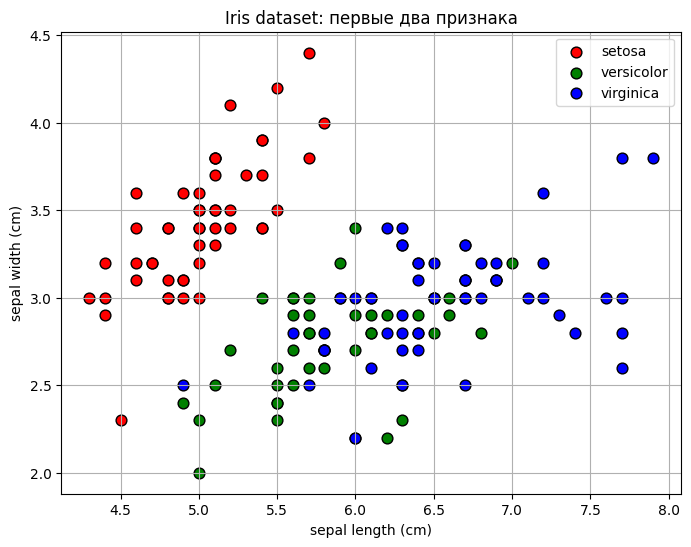

In [3]:
X = data.data[:, :2]  # первые два признака: длина и ширина чашелистика
y = data.target

plt.figure(figsize=(8, 6))
for class_value, color, label in zip([0, 1, 2], ['red', 'green', 'blue'], data.target_names):
    plt.scatter(X[y == class_value, 0], X[y == class_value, 1], c=color, label=label, edgecolor='k', s=60)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
plt.title('Iris dataset: первые два признака')
plt.legend()
plt.grid(True)
plt.show()

Выберем классы: setosa (0) и versicolor (1):

In [4]:
mask = y < 2
X = X[mask]
y = y[mask]
# Превратим метки в ±1 для функции sgn
y = np.where(y == 0, -1, 1)

Масштабируем, функция `fit_tranform` подбирает коэффициенты (`fit`) и применяет к множеству (`transform`):

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Формула линейного классификатора с функцией знака (sgn):

$$
\hat{y} = \operatorname{sgn}(\mathbf{w} \cdot \mathbf{x} + b) =
\begin{cases}
+1, & \text{если } \mathbf{w} \cdot \mathbf{x} + b \geq 0 \\
-1, & \text{иначе}
\end{cases}
$$

где  $\mathbf{x} \in \mathbb{R}^n$ — вектор признаков,  $\mathbf{w} \in \mathbb{R}^n$ — вектор весов,  $b \in \mathbb{R}$ — смещение (bias).


### Обучение линейного классификатора
Реализуем следующий простой алгоритм обучения:

1. Инициализирует веса нулями и смещение нулём.  
2. Для каждого примера вычисляет предсказание с помощью функции знака:  
  $$ \hat{y} = \operatorname{sgn}(\mathbf{w} \cdot \mathbf{x} + b) $$  
3. Если предсказание не совпадает с истинной меткой $y$, обновляет веса и смещение по правилу:  
  $$ \mathbf{w} \leftarrow \mathbf{w} + \eta (y - \hat{y}) \mathbf{x}, b \leftarrow b + \eta (y - \hat{y}) $$  
4. Повторяет, пока не пройдёт заданное число эпох или не сойдётся.  

Таким образом модель постепенно смещает и поворачивает разделяющую прямую, улучшая качество классификации.

In [6]:
class LinearClassifier:
    def __init__(self, lr=0.1, epochs=10):
        self.lr = lr # скорость обучения
        self.epochs = epochs # число эпох
        self.w = None
        self.b = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.w) + self.b
                y_pred = 1 if linear_output >= 0 else -1
                update = self.lr * (y[idx] - y_pred)
                self.w += update * x_i
                self.b += update

    def predict(self, X):
        linear_output = X.dot(self.w) + self.b
        return np.where(linear_output >= 0, 1, -1)


Попробуем в деле и выведем результат с precision, recall, f1-score для каждого класса:

In [7]:
X_train, X_test, y_train_signed, y_test_signed = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# обучение
clf = LinearClassifier(lr=0.1, epochs=30)
clf.fit(X_train, y_train_signed)

y_pred_signed = clf.predict(X_test)
# {-1,+1} -> {0,1} для sklearn
y_test = (y_test_signed == 1).astype(int)
y_pred = (y_pred_signed == 1).astype(int)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.938     1.000     0.968        15
           1      1.000     0.933     0.966        15

    accuracy                          0.967        30
   macro avg      0.969     0.967     0.967        30
weighted avg      0.969     0.967     0.967        30



Посмотрим на нашу прямую:

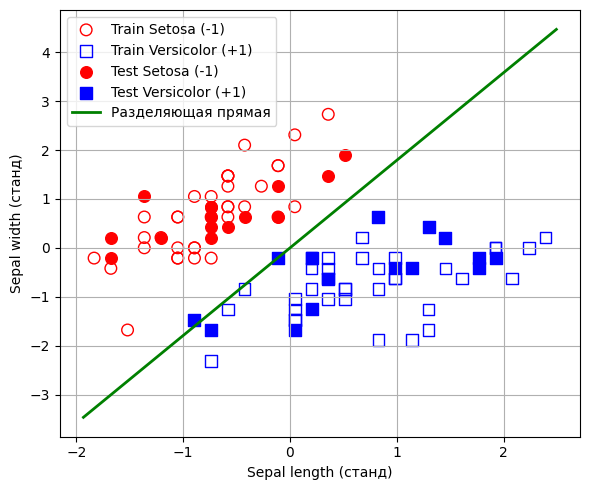

In [8]:
plt.figure(figsize=(6,5))
plt.scatter(X_train[y_train_signed==-1,0], X_train[y_train_signed==-1,1],
            facecolors='none', edgecolors='red', marker='o', s=70, label='Train Setosa (-1)')
plt.scatter(X_train[y_train_signed==1,0], X_train[y_train_signed==1,1],
            facecolors='none', edgecolors='blue', marker='s', s=70, label='Train Versicolor (+1)')
plt.scatter(X_test[y_test_signed==-1,0], X_test[y_test_signed==-1,1],
            color='red', marker='o', s=70, label='Test Setosa (-1)')
plt.scatter(X_test[y_test_signed==1,0], X_test[y_test_signed==1,1],
            color='blue', marker='s', s=70, label='Test Versicolor (+1)')
xmin = min(X_train[:,0].min(), X_test[:,0].min()) - 0.1
xmax = max(X_train[:,0].max(), X_test[:,0].max()) + 0.1
x1_vals = np.linspace(xmin, xmax, 200)
x2_vals = -(clf.w[0] / clf.w[1]) * x1_vals - clf.b / clf.w[1]

plt.plot(x1_vals, x2_vals, color='green', linewidth=2, label='Разделяющая прямая')

plt.xlabel('Sepal length (станд)')
plt.ylabel('Sepal width (станд)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

**Упражнение 1:** реализуйте функцию потерь Hinge и градиентный спуск для неё, сравните результаты.
$$ L(\mathbf{w}, b) = 1 - \sum_{i \in M} y_i (\mathbf{w} \cdot \mathbf{x}_i + b) $$

In [9]:
def hinge_loss(w, b, X, y, margin=1.0):
    margins = y * (X.dot(w) + b)
    return np.maximum(0, margin - margins).mean()

def train_hinge_sgd(X, y, lr=0.05, epochs=300, lambda_reg=0.01):
    w = np.zeros(X.shape[1])
    b = 0.0
    for _ in range(epochs):
        margins = y * (X.dot(w) + b)
        mis = margins < 1
        if np.any(mis):
            grad_w = -np.mean(y[mis][:, None] * X[mis], axis=0) + lambda_reg * w
            grad_b = -np.mean(y[mis])
        else:
            grad_w = lambda_reg * w
            grad_b = 0.0
        w -= lr * grad_w
        b -= lr * grad_b
    return w, b

w_hinge, b_hinge = train_hinge_sgd(X_train, y_train_signed)
y_pred_hinge = np.where((X_test @ w_hinge + b_hinge) >= 0, 1, -1)
y_pred_hinge_01 = (y_pred_hinge == 1).astype(int)
print("Hinge loss на тесте:", hinge_loss(w_hinge, b_hinge, X_test, y_test_signed))
print(classification_report(y_test, y_pred_hinge_01, digits=3))


Hinge loss на тесте: 0.01708983484179832
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        15
           1      1.000     1.000     1.000        15

    accuracy                          1.000        30
   macro avg      1.000     1.000     1.000        30
weighted avg      1.000     1.000     1.000        30



**Упражнение 2**: реализуйте матрицу несоответствий для данного решения.
\begin{equation}
M = 
\begin{pmatrix}
TP & FN \\
FP & TN
\end{pmatrix},
\end{equation}
где $TP$ — истинно положительные, $FN$ — ложно отрицательные, $FP$ — ложно положительные, $TN$ — истинно отрицательные случаи.

In [10]:
def confusion_matrix(y_test, y_pred):  # к упражнению 2
    y_test = np.asarray(y_test)
    y_pred = np.asarray(y_pred)
    tp = np.sum((y_test == 1) & (y_pred == 1))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    return [[tp, fn], [fp, tn]]


**Упражнение 3**: реализуйте логистическую регрессию и сравните результаты.

In [11]:
class LogisticRegression:
    def __init__(self, lr=0.1, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        # приводим метки к {0,1}
        y_bin = ((y == 1) | (y == 1.0)).astype(float)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0.0
        for _ in range(self.epochs):
            linear = X.dot(self.w) + self.b
            y_hat = self._sigmoid(linear)
            dw = (1 / n_samples) * X.T.dot(y_hat - y_bin)
            db = (y_hat - y_bin).mean()
            self.w -= self.lr * dw
            self.b -= self.lr * db
        return self

    def predict_proba(self, X):
        linear = X.dot(self.w) + self.b
        return self._sigmoid(linear)

    def predict(self, X):
        y_predicted = self.predict_proba(X)
        return np.where(y_predicted >= 0.5, 1, -1)


In [12]:
log_clf = LogisticRegression(lr=0.1, epochs=3000)
log_clf.fit(X_train, y_train_signed)
log_pred_signed = log_clf.predict(X_test)
log_pred = (log_pred_signed == 1).astype(int)
print(classification_report(y_test, log_pred, digits=3))


              precision    recall  f1-score   support

           0      1.000     1.000     1.000        15
           1      1.000     1.000     1.000        15

    accuracy                          1.000        30
   macro avg      1.000     1.000     1.000        30
weighted avg      1.000     1.000     1.000        30



## Метод опорных векторов

In [13]:
from sklearn.svm import SVC, LinearSVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_moons
X, y = make_moons(noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Попробуем более интересный датасет, где линейное разделение уже не даст результата.

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.71      1.00      0.83        10

    accuracy                           0.87        30
   macro avg       0.86      0.90      0.86        30
weighted avg       0.90      0.87      0.87        30



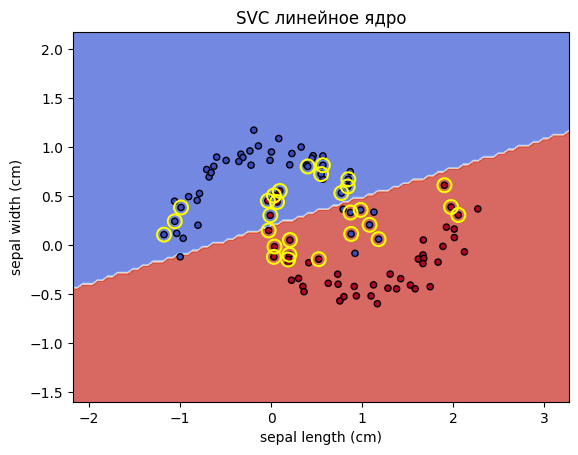

In [14]:
clf = SVC(kernel="linear",C=0.8)
clf.fit(X_train, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict", cmap=plt.cm.coolwarm, alpha=0.8,
    xlabel=data.feature_names[0], ylabel=data.feature_names[1]
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.title("SVC линейное ядро")
support_vectors = clf.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
            s=100, facecolors='none', edgecolors='yellow', 
            label='Опорные вектора', linewidths=1.5)
print(classification_report(y_test, clf.predict(X_test)))

Применим нелинейное ядро:  
$$
K(\mathbf{x}, \mathbf{x}') = \exp\left(-\gamma \|\mathbf{x} - \mathbf{x}'\|^2\right),
$$
где  
- $\mathbf{x}, \mathbf{x}'$ — объекты из пространства признаков,  
- $\|\mathbf{x} - \mathbf{x}'\|$ — евклидово расстояние между точками,  
- $\gamma > 0$ — параметр ядра, контролирующий радиус действия влияния одной опорной точки.


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



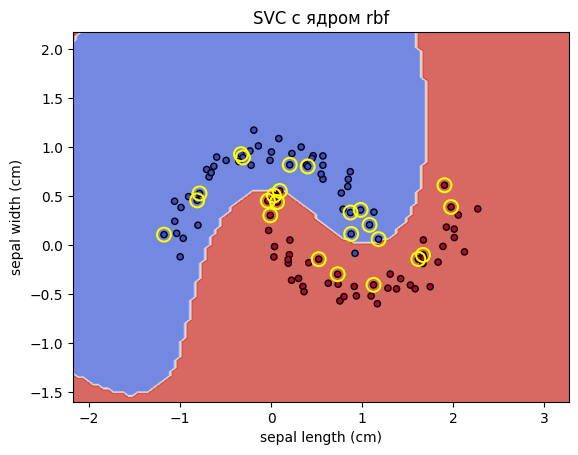

In [15]:
clf = SVC(kernel="rbf")
clf.fit(X_train, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict", cmap=plt.cm.coolwarm, alpha=0.8,
    xlabel=data.feature_names[0], ylabel=data.feature_names[1]
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.title("SVC с ядром rbf")
support_vectors = clf.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
            s=100, facecolors='none', edgecolors='yellow', 
            label='Опорные вектора', linewidths=1.5)
print(classification_report(y_test, clf.predict(X_test)))


Регуляризуем, тем самым уменьшим полосу разделения:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



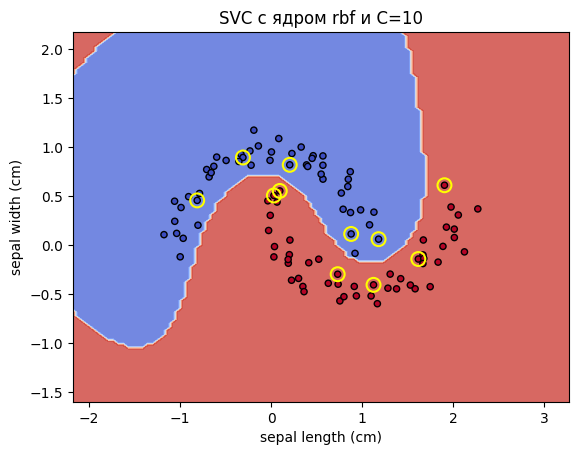

In [16]:
clf = SVC(kernel="rbf",C=10)
clf.fit(X_train, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict", cmap=plt.cm.coolwarm, alpha=0.8,
    xlabel=data.feature_names[0], ylabel=data.feature_names[1]
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
support_vectors = clf.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
            s=100, facecolors='none', edgecolors='yellow', 
            label='Опорные вектора', linewidths=1.5)
plt.title("SVC с ядром rbf и C=10")
print(classification_report(y_test, clf.predict(X_test)))

**Упражнение 4:** подберите наилучшее разделение для трех классов ирисов.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.70      0.54      0.61        13
           2       0.62      0.77      0.69        13

    accuracy                           0.80        45
   macro avg       0.78      0.77      0.77        45
weighted avg       0.81      0.80      0.80        45



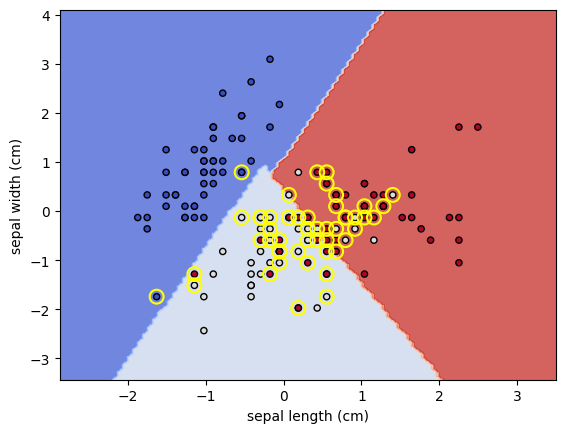

In [17]:
data = load_iris()
X = data.data[:, :2]
y = data.target
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = SVC(kernel="linear", C=10)
#SVC(kernel="rbf", gamma=0.7, C=10),
#SVC(kernel="poly", degree=3, gamma="auto", C=10)

clf.fit(X_train, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict", cmap=plt.cm.coolwarm, alpha=0.8,
    xlabel=data.feature_names[0], ylabel=data.feature_names[1]
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
support_vectors = clf.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
            s=100, facecolors='none', edgecolors='yellow', 
            label='Опорные вектора', linewidths=1.5)
print(classification_report(y_test, clf.predict(X_test)))

## Метод ближайшего соседа

Обучим классификатор с параметрами по умолчанию:

In [18]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.70      0.54      0.61        13
           2       0.62      0.77      0.69        13

    accuracy                           0.80        45
   macro avg       0.78      0.77      0.77        45
weighted avg       0.81      0.80      0.80        45



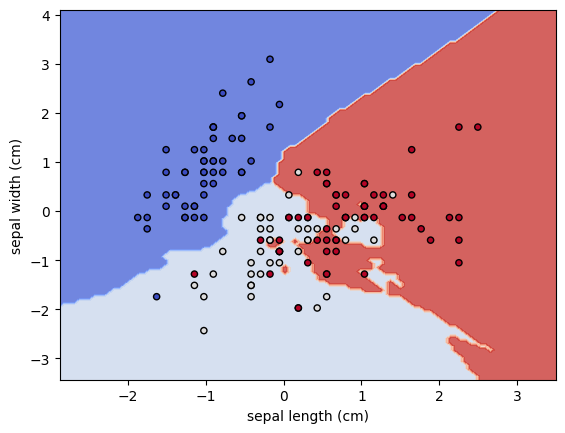

In [19]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf_knn, X, response_method="predict", cmap=plt.cm.coolwarm, alpha=0.8,
    xlabel=data.feature_names[0], ylabel=data.feature_names[1]
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
print(classification_report(y_test, clf.predict(X_test)))

Подбирать параметры вручную довольно занудно. Попробуем подбирать их при помощи поиска по сетке (GridSearchCV) с кросс-валидацией. GridSearchCV перебирает все заданные комбинации параметров модели. Для каждой комбинации выполняется кросс-валидация:  
- Данные разбиваются на несколько частей (folds).  
- Модель обучается на части и тестируется на оставшейся.  

В итоге выбираются параметры с лучшим усреднённым результатом, что позволяет автоматизировать подбор гиперпараметров.

In [20]:
param_grid = {
    'n_neighbors': range(1,15), # число соседей
    'metric': ['euclidean', 'manhattan','cosine'] # метрика
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='f1_macro',verbose=2) 
# запускаем grid search с 3 фолдами на лучшее f1 с макроусреднением
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее качество на кросс-валидации:", grid_search.best_score_)

# Лучший классификатор
best_knn = grid_search.best_estimator_

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] END ....................metric=euclidean, n_neighbors=1; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=1; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=1; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=2; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=2; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=2; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=4; total time=   0.0s
[CV] END ....................metric=euclidean, n_neighbors=4; total time=   0.0s
[CV] END ....................metric=euclidean, 

[CV] END ...................metric=euclidean, n_neighbors=10; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=10; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=11; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=11; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=11; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=12; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=12; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=12; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=13; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=13; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=13; total time=   0.0s
[CV] END ...................metric=euclidean, n_neighbors=14; total time=   0.0s
[CV] END ...................

[CV] END ...................metric=manhattan, n_neighbors=14; total time=   0.0s
[CV] END ...................metric=manhattan, n_neighbors=14; total time=   0.0s
[CV] END ...................metric=manhattan, n_neighbors=14; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=1; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=1; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=1; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=2; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=2; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=2; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=3; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=3; total time=   0.0s
[CV] END .......................metric=cosine, n_neighbors=3; total time=   0.0s
[CV] END ...................

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.70      0.54      0.61        13
           2       0.62      0.77      0.69        13

    accuracy                           0.80        45
   macro avg       0.78      0.77      0.77        45
weighted avg       0.81      0.80      0.80        45



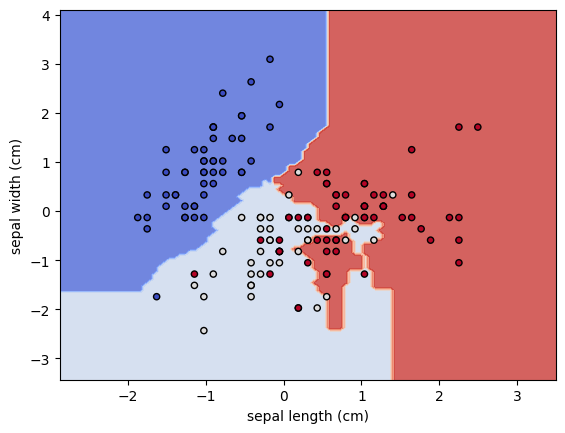

In [21]:
best_knn.fit(X_train, y_train) # берем наилучший классификатор
disp = DecisionBoundaryDisplay.from_estimator(
    best_knn, X, response_method="predict", cmap=plt.cm.coolwarm, alpha=0.8,
    xlabel=data.feature_names[0], ylabel=data.feature_names[1]
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
print(classification_report(y_test, clf.predict(X_test)))

**Упражнение 5**: используйте GridSearchCV для подбора лучших параметров метода опорных векторов для последнего множества, сравните результаты.

## Наивный байесовский классификатор и логистическая регрессия

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import RocCurveDisplay, roc_auc_score

**Упражнение 6:** реализуйте наивный байесовский классификатор.
Для бинарных признаков $\mathbf{x} = (x_1, \dots, x_n)$, где $x_j \in \{0,1\}$, и класса $c$:
- Априорная вероятность класса с лапласовским сглаживанием:
$$
P(c) = \frac{\text{число объектов класса } c}{\text{общее число объектов}}
$$
- Вероятность признака при классе с лапласовским сглаживанием:
$$
\theta_{j|c} = P(x_j=1 \mid c) = \frac{\sum_{i:y_i=c} x_{ij} + 1}{N_c + 2}
$$
где $N_c$ — число объектов класса $c$.
- Вероятность объекта при классе:
$$
P(\mathbf{x} \mid c) = \prod_{j=1}^n \theta_{j|c}^{x_j} (1 - \theta_{j|c})^{1 - x_j}
$$
- Для вычислений используем логарифмы (чтобы избежать переполнения):
$$
\log P(c \mid \mathbf{x}) \propto \log P(c) + \sum_{j=1}^n \left[ x_j \log \theta_{j|c} + (1 - x_j) \log (1 - \theta_{j|c}) \right]
$$

In [23]:
class SimpleBernoulliNB:
    """Простая реализация наивного байесовского классификатора для бинарных признаков."""
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.classes_ = None
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.feature_log_neg_prob_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_, counts = np.unique(y, return_counts=True)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        self.class_log_prior_ = np.log(counts / len(y))
        self.feature_log_prob_ = np.zeros((n_classes, n_features))
        self.feature_log_neg_prob_ = np.zeros((n_classes, n_features))
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            theta = (X_c.sum(axis=0) + self.alpha) / (X_c.shape[0] + 2 * self.alpha)
            self.feature_log_prob_[idx] = np.log(theta)
            self.feature_log_neg_prob_[idx] = np.log(1 - theta)
        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        log_probs = []
        for idx, _ in enumerate(self.classes_):
            lp = (self.class_log_prior_[idx] + (X * self.feature_log_prob_[idx]).sum(axis=1) + ((1 - X) * self.feature_log_neg_prob_[idx]).sum(axis=1))
            log_probs.append(lp)
        log_probs = np.vstack(log_probs).T  # shape (n_samples, n_classes)
        max_log = np.max(log_probs, axis=1, keepdims=True)
        probs = np.exp(log_probs - max_log)
        probs /= probs.sum(axis=1, keepdims=True)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        class_indices = np.argmax(probs, axis=1)
        return self.classes_[class_indices]


### Классификация текстов

Рассмотрим датасет для классификации текстов. Для преобразования текстов в удобный для классификатора вид используем  `CountVectorizer(binary=True)`, который преобразует тексты в бинарные векторы признаков.
- Строит словарь всех слов из корпуса.  
- Для каждого текста создаёт вектор:  
  - `1`, если слово присутствует;  
  - `0`, если отсутствует.  

Используется для представления текста в виде *"мешка слов"* (bag-of-words) без учёта частоты.

Логистическая регрессия ROC AUC: 0.75


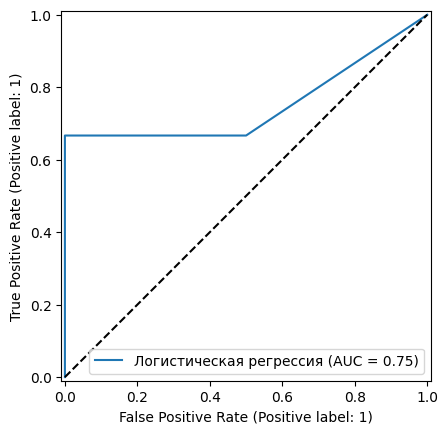

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay

texts = [
    "материалы ректорского совещания",
    "объявление о проведении уборочных работ",
    "лекция ML в механике",
    "напоминание о сдаче блокнота",
    "результаты сессии и пересдачи",
    "объявление о закрытии библиотеки на ремонт",
    "deadline по сдаче блокнота",
    "график консультаций преподавателей",
    "срочно! последний день для сдачи блокнота",
    "обновление сдвиг сдачи работ",
]
y = np.array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1])  # 1 — спам, 0 — не спам

vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(texts).toarray() # векторизуем в бинарные признаки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

#clf_simple = SimpleBernoulliNB().fit(X_train, y_train)
clf_lr = LogisticRegression().fit(X_train, y_train) # тренируем

y_score_lr = clf_lr.predict_proba(X_test)[:, 1] # предсказываем

print("Логистическая регрессия ROC AUC:", roc_auc_score(y_test, y_score_lr))
RocCurveDisplay.from_predictions(y_test, y_score_lr, name="Логистическая регрессия")
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

### breast cancer dataset

Рассмотрим еще один популярный датасет на медицинскую тему:

**breast_cancer**
Классический медицинский датасет для бинарной классификации — диагностика опухолей молочной железы.
Необходимо предсказать, является ли опухоль *злокачественной* (*malignant*) или *доброкачественной* (*benign*).
*Количество объектов:*  569 образцов.
*Количество признаков:*  30 числовых признаков, рассчитанных по микроскопическим изображениям клеток.

**Примеры признаков:**
- `mean radius` — средний радиус клеток  
- `mean texture` — неоднородность структуры  
- `mean smoothness` — гладкость поверхности  
- `mean concavity` — вогнутость границ  
- `mean symmetry` — симметрия клеток

In [25]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target

# Бинаризация по медиане каждого признака
thresholds = np.median(X, axis=0)
X_bin = (X > thresholds).astype(int)

# используем только первые 15 признаков
X_train, X_test, y_train, y_test = train_test_split(X_bin[:,:15], y, stratify=y, random_state=42)

Чтобы сравнить результаты, используем кривую ROC_AUC:

In [26]:
feature_options = [20, 25, 30]
results = []
for n_features in feature_options:
    X_subset = X_bin[:, :n_features]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, stratify=y, random_state=42)
    custom_nb = SimpleBernoulliNB().fit(X_train, y_train)
    sklearn_nb = BernoulliNB().fit(X_train, y_train)
    y_score_custom = custom_nb.predict_proba(X_test)[:, 1]
    y_score_sklearn = sklearn_nb.predict_proba(X_test)[:, 1]
    results.append({
        "features": n_features,
        "custom_auc": roc_auc_score(y_test, y_score_custom),
        "sklearn_auc": roc_auc_score(y_test, y_score_sklearn),
        "custom_acc": accuracy_score(y_test, custom_nb.predict(X_test)),
        "sklearn_acc": accuracy_score(y_test, sklearn_nb.predict(X_test)),
    })

pd.DataFrame(results)


,features,custom_auc,sklearn_auc,custom_acc,sklearn_acc
0,20,0.960168,0.960168,0.888112,0.888112
1,25,0.972746,0.972746,0.916084,0.916084
2,30,0.976730,0.976730,0.923077,0.923077


In [27]:
# Можно выбрать лучшее число признаков
best = max(results, key=lambda r: r["sklearn_auc"])
print(f"Лучшее число признаков по AUC (sklearn NB): {best["features"]}, AUC={best["sklearn_auc"]:.3f}")


Лучшее число признаков по AUC (sklearn NB): 30, AUC=0.977


## Steel Plates Faults Dataset

*Источник:* [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/steel+plates+faults)  
*Назначение:* Классификация дефектов поверхности стальных листов  
*Размер:* 1941 наблюдение × 33 признака  
*Тип данных:* числовые (float, бинарные флаги)

**Основные признаки**:
- `X_Minimum`, `X_Maximum`, `Y_Minimum`, `Y_Maximum` — координаты дефекта  
- `Pixels_Areas`, `LogOfAreas`, `SigmoidOfAreas` — площадь и её преобразования  
- `X_Perimeter`, `Y_Perimeter` — форма дефекта  
- `Sum_of_Luminosity`, `Minimum_of_Luminosity`, `Maximum_of_Luminosity`, `Luminosity_Index` — показатели яркости  
- `Length_of_Conveyer`, `Steel_Plate_Thickness` — технологические параметры  
- `TypeOfSteel_A300`, `TypeOfSteel_A400` — тип стали (one-hot признаки)  
- `Edges_Index`, `Empty_Index`, `Square_Index`, `Outside_X_Index`, `Edges_X_Index`, `Edges_Y_Index`, `Outside_Global_Index`, `Log_X_Index`, `Log_Y_Index`, `Orientation_Index` — геометрические и морфологические характеристики дефектов  

**Целевые переменные (дефекты)**:
- `Pastry` -- расслоение
- `Z_Scratch` -- царапина Z
- `K_Scatch` -- царапина K
- `Stains` -- пятна
- `Dirtiness` -- грязь
- `Bumps`  -- вздутия
- `Other_Faults` -- прочее

In [28]:
from pathlib import Path
titles = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
data_path = Path("datasets/Faults.NNA")
if data_path.exists():
    df = pd.read_csv(data_path, sep="	", header=None, names=titles)
    print("Загрузили реальный датасет Faults.NNA")
else:
    rng = np.random.default_rng(42)
    df = pd.DataFrame(rng.normal(size=(200, len(titles))), columns=titles)
    print("Файл Faults.NNA не найден, используем синтетические данные для демонстрации.")


Файл Faults.NNA не найден, используем синтетические данные для демонстрации.


## Разведочный анализ данных

In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,200.0,0.076814,0.961812,-2.478757,-0.522265,0.173407,0.728214,2.703985
X_Maximum,200.0,0.148433,1.133635,-2.345788,-0.649052,0.126001,0.852407,3.023781
Y_Minimum,200.0,-0.081477,0.970046,-2.749435,-0.716763,-0.047841,0.562094,2.471809
Y_Maximum,200.0,-0.054775,0.977948,-2.334177,-0.672278,-0.123043,0.597324,2.913862
Pixels_Areas,200.0,-0.071792,0.991153,-2.501700,-0.742212,-0.106202,0.659665,2.799697
X_Perimeter,200.0,-0.044312,1.031336,-2.327100,-0.812836,-0.044469,0.576725,2.739504
Y_Perimeter,200.0,0.004475,1.047441,-2.180210,-0.696889,-0.127142,0.681963,3.271026
Sum_of_Luminosity,200.0,-0.047059,1.045196,-2.869620,-0.741985,-0.001632,0.562594,3.059531
Minimum_of_Luminosity,200.0,0.083673,1.006736,-2.280738,-0.710625,0.063338,0.828169,2.800086
Maximum_of_Luminosity,200.0,0.033476,1.047485,-2.955619,-0.653582,0.158191,0.771897,2.277430


In [30]:
df.corr(numeric_only=True).style.format("{:.2f}").background_gradient(cmap="coolwarm")

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
X_Minimum,1.00,-0.05,0.17,0.04,0.04,-0.01,-0.07,-0.07,0.04,-0.11,0.01,-0.03,-0.13,0.05,-0.09,0.13,-0.03,-0.09,-0.06,0.01,0.04,-0.00,-0.08,-0.07,0.09,-0.12,-0.01,0.03,-0.00,0.13,0.12,-0.08,-0.11,0.16
X_Maximum,-0.05,1.00,-0.05,-0.09,-0.06,-0.03,0.05,0.01,0.06,-0.02,-0.03,-0.07,0.05,-0.10,0.06,0.03,-0.07,-0.08,-0.03,-0.09,0.12,0.11,-0.01,0.10,0.06,0.12,0.03,0.01,-0.03,0.08,-0.02,0.02,-0.01,0.03
Y_Minimum,0.17,-0.05,1.00,-0.01,0.09,-0.05,0.02,-0.04,0.04,0.02,0.02,-0.09,0.02,0.28,0.06,0.03,-0.09,0.05,0.08,-0.00,0.00,-0.05,-0.02,-0.07,0.02,-0.02,0.06,0.04,0.15,0.15,0.06,0.00,-0.00,-0.05
Y_Maximum,0.04,-0.09,-0.01,1.00,0.05,-0.02,0.03,-0.02,0.05,0.08,-0.05,0.03,0.08,-0.08,-0.04,0.06,0.08,-0.07,0.11,0.11,-0.02,-0.04,-0.08,0.02,0.08,-0.06,-0.00,0.06,0.01,-0.11,-0.01,-0.05,0.18,-0.02
Pixels_Areas,0.04,-0.06,0.09,0.05,1.00,0.13,-0.08,0.05,-0.04,0.12,-0.10,0.00,0.05,0.10,0.08,-0.04,-0.12,0.10,0.10,-0.02,-0.01,0.04,-0.14,-0.09,-0.06,-0.01,0.05,0.04,0.10,0.16,-0.02,0.07,0.10,0.02
X_Perimeter,-0.01,-0.03,-0.05,-0.02,0.13,1.00,0.09,0.07,0.03,0.05,-0.06,-0.03,-0.00,0.00,0.01,0.01,0.03,0.01,0.07,-0.07,-0.09,0.05,-0.02,0.02,-0.07,-0.06,0.03,-0.14,0.04,-0.09,0.11,-0.07,0.06,0.12
Y_Perimeter,-0.07,0.05,0.02,0.03,-0.08,0.09,1.00,-0.04,0.02,0.04,-0.03,0.13,-0.01,-0.02,-0.01,0.08,0.06,0.03,-0.04,-0.02,0.06,-0.10,-0.07,0.04,0.09,0.13,0.00,-0.05,0.02,-0.08,0.04,0.04,-0.02,0.02
Sum_of_Luminosity,-0.07,0.01,-0.04,-0.02,0.05,0.07,-0.04,1.00,0.07,-0.06,-0.02,-0.07,-0.02,0.09,-0.07,-0.03,-0.17,-0.11,-0.01,0.01,0.03,0.01,0.03,0.00,-0.03,0.16,-0.05,0.07,-0.08,0.02,-0.08,-0.04,0.05,0.04
Minimum_of_Luminosity,0.04,0.06,0.04,0.05,-0.04,0.03,0.02,0.07,1.00,0.07,0.04,-0.05,0.09,-0.03,-0.09,0.01,-0.04,0.02,0.08,0.03,0.08,-0.13,-0.00,0.08,-0.00,0.13,-0.11,-0.10,-0.08,-0.01,-0.08,0.07,0.05,-0.09
Maximum_of_Luminosity,-0.11,-0.02,0.02,0.08,0.12,0.05,0.04,-0.06,0.07,1.00,0.03,-0.03,0.06,-0.03,0.07,0.03,0.18,0.05,-0.03,-0.07,0.01,0.01,0.02,0.02,-0.03,0.00,0.04,-0.04,0.11,0.04,-0.08,-0.03,0.08,-0.02


In [31]:
print(df[['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']].apply(pd.Series.value_counts))

           Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
-3.648413     NaN        NaN       NaN     NaN        1.0    NaN           NaN
-3.131905     NaN        NaN       NaN     NaN        NaN    NaN           1.0
-3.110488     NaN        NaN       NaN     NaN        1.0    NaN           NaN
-3.063780     NaN        NaN       NaN     NaN        1.0    NaN           NaN
-2.964529     NaN        1.0       NaN     NaN        NaN    NaN           NaN
...           ...        ...       ...     ...        ...    ...           ...
 2.671763     NaN        1.0       NaN     NaN        NaN    NaN           NaN
 2.731289     NaN        1.0       NaN     NaN        NaN    NaN           NaN
 3.178854     NaN        NaN       NaN     1.0        NaN    NaN           NaN
 3.208161     NaN        NaN       NaN     NaN        NaN    NaN           1.0
 3.454046     1.0        NaN       NaN     NaN        NaN    NaN           NaN

[1400 rows x 7 columns]


**Упражнение (со звездочкой)**: сравните и подберите наилучший алгоритм классификации для Bumps из рассмотренных, подберите наилучшие гиперпараметры. Постройте график ROC для всех моделей на одной оси и прокомментируйте, какая из них ведёт себя наиболее устойчиво.